In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox
import matplotlib.pyplot as plt

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

In [3]:
# change to your custom locations
data_dir = "/data/S1"
ids = ['S1A_IW_SLC__1SDV_20181228T050448_20181228T050515_025221_02C9BE_1E22']
primary_dir = f"{data_dir}/{ids[0]}.zip"
outputs_prefix_flattened="/data/res/etna-flattened"
outputs_prefix_beta="/data/res/etna-beta"

## Download S-1 products

In [ ]:
# load a geometry
# file_aoi = "../data/Etna.geojson"
file_aoi = "https://raw.githubusercontent.com/odhondt/eo_tools/refs/heads/main/data/Etna.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2018-12-22",
    "end": "2018-12-29",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Geocoding with terrain flattening

In [ ]:
from eo_tools.S1.process import process_slc

out_dir_flattened = process_slc(
    dir_slc=primary_dir,
    outputs_prefix=outputs_prefix_flattened,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    multilook=[1, 4],
    warp_kernel="bicubic",
    cal_type="terrain",
    clip_to_shape=True,
)

## Geocoding with beta nought for comparison

In [ ]:
from eo_tools.S1.process import process_slc

out_dir_beta = process_slc(
    dir_slc=primary_dir,
    outputs_prefix=outputs_prefix_beta,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    multilook=[1, 4],
    warp_kernel="bicubic",
    cal_type="beta",
    clip_to_shape=True,
)

# Display results

Text(0.5, 1.0, 'terrain normalization')

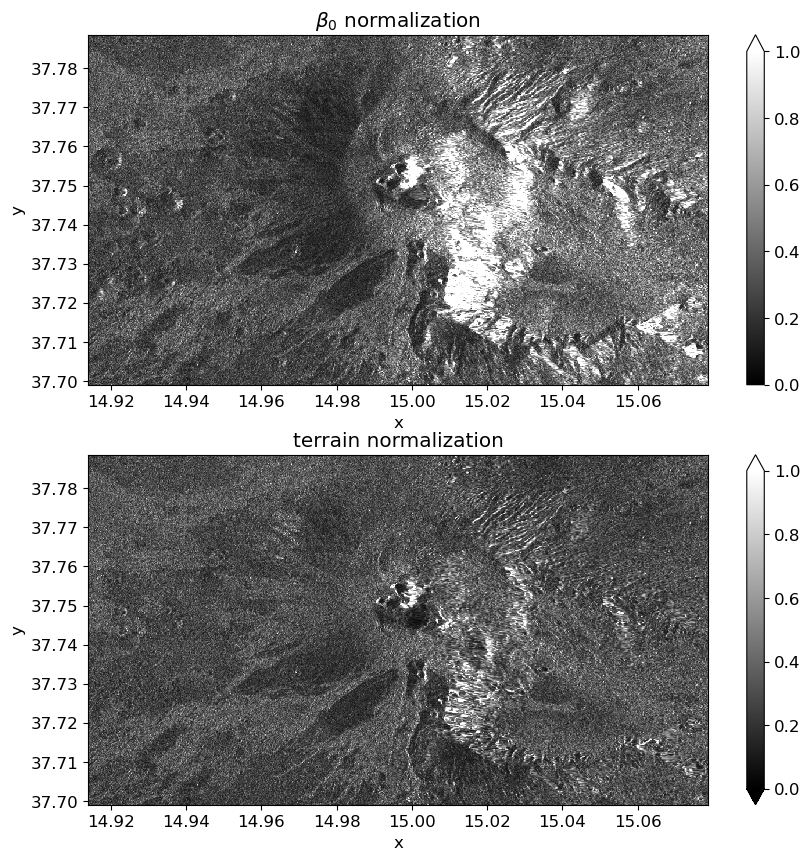

In [12]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
arr_b = riox.open_rasterio(f"{out_dir_beta}/amp_vv.tif")[0]
arr_b.plot.imshow(vmin=0, vmax=1, cmap="gray", ax=axs[0])
axs[0].set_title("$\\beta_0$ normalization")
arr_f = riox.open_rasterio(f"{out_dir_flattened}/amp_vv.tif")[0]
arr_f.plot.imshow(vmin=0, vmax=1, cmap="gray", ax=axs[1])
axs[1].set_title("terrain normalization")